### 读取数据

In [3]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertTokenizer
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

D:\anaconda\envs\nn6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anaconda\envs\nn6\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [1]:
import h5py
import numpy as np
def byte2str(data):
    data = list(data)
    for i, item in enumerate(data):
        data[i] = item.decode('utf-8')
    return data
def load_dataset(file_path, train_ratio=0.8, random_seed=1):
    # Load the dataset from the file
    with h5py.File( file_path , 'r') as f:
        data = {}
        for key in f.keys():
            data[key] = np.array(f[key])

    # Shuffle the data indices
    num_examples = len(data['labels'])
    indices = np.arange(num_examples)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(indices)

    # Split the data into training and testing sets
    split_index = int(num_examples * train_ratio)
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    train_data = {key: data[key][train_indices] for key in data}
    test_data = {key: data[key][test_indices] for key in data}
    
    train_data['texts'], train_data['labels'] = byte2str(train_data['texts']), byte2str(train_data['labels'])
    test_data['texts'], test_data['labels'] = byte2str(test_data['texts']), byte2str(test_data['labels'])
    
    label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
    train_data['labels_ids'] = [label2id[label] for label in train_data['labels']]
    test_data['labels_ids'] = [label2id[label] for label in test_data['labels']]
    
    return (np.array(train_data['images']), np.array(train_data['texts']), np.array(train_data['labels']),
            np.array(train_data['labels_ids']), np.array(test_data['images']), np.array(test_data['texts']),
            np.array(test_data['labels']), np.array(test_data['labels_ids'])) 

file_path = 'MVSA_Single/dataset.h5'
train_data , test_data = {} , {} 
train_data['image'], train_data['text'], train_data['label'], train_data['labels_id'],\
test_data['image'], test_data['text'], test_data['label'], test_data['labels_id']\
= load_dataset(file_path)

In [4]:
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        #加载VGG16预训练模型
        self.vgg16 = models.vgg16(pretrained=True)
        # 去掉全连接层
        self.features = nn.Sequential(*list(self.vgg16.children())[:-1])
        # 冻结参数
        for param in self.features.parameters():
            param.requires_grad = False
        # 添加新的全连接层以便训练任务
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 3)
 
    def forward(self, x_image):
        # 将图像作为VGG16的输入
        features = self.features(x_image)
        # 将输出的特征展开
        flatten = nn.Flatten()(features)
        # 用全连接层提取特征
        fc1_out = self.fc1(flatten)
        
        # Apply the second fully connected layer
        fc2_out = self.fc2(fc1_out)
        
        # Apply softmax activation to obtain class probabilities
        prob_out = F.softmax(fc2_out, dim=1)
        
        return prob_out
#         return fc1_out

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class ImgDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data['image'])

    def __getitem__(self, index):
        x = self.data['image'][index]
        x = x.transpose((2, 0, 1))
        # 转换图像数据类型为 float32
        x = x.astype('float32')
        # 归一化图像数据到 [0, 1] 区间
        x /= 255
        
        y = self.data['labels_id'][index]

        if self.transform:
            x = self.transform(x)

        return {'image': x, 'labels_id': y}

# 创建数据集对象
imgdataset = ImgDataset(train_data)
# textdataset = TextDatasert(train_data)
# 创建数据加载器对象
batch_size = 32
img_train_loader = DataLoader(imgdataset, batch_size=batch_size, shuffle=True, drop_last=True)
# text_train_loader = DataLoader(textdataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [15]:
imgmodel = ImageModel().to('cuda')

In [17]:
import torch.optim as optim
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(imgmodel.parameters(), lr=0.0001)

[1,    20] loss: 0.246
[1,    40] loss: 0.244
[1,    60] loss: 0.247
[1,    80] loss: 0.252
[1,   100] loss: 0.246
[1,   120] loss: 0.244
[2,    20] loss: 0.244
[2,    40] loss: 0.241
[2,    60] loss: 0.242
[2,    80] loss: 0.246
[2,   100] loss: 0.246
[2,   120] loss: 0.248
[3,    20] loss: 0.242
[3,    40] loss: 0.243
[3,    60] loss: 0.246
[3,    80] loss: 0.245
[3,   100] loss: 0.244
[3,   120] loss: 0.245


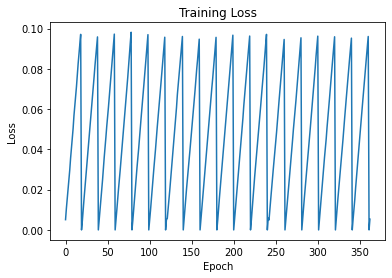

In [20]:
import matplotlib.pyplot as plt
# 训练模型
imgloss_list = []
num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(img_train_loader, 0):
        # 获取输入数据和标签
        inputs, labels = data['image'], data['labels_id'].long()

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        # 将梯度归零
        optimizer.zero_grad()

        # 前向传递
        outputs = imgmodel(inputs)

        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()

        # 更新权重
        optimizer.step()

        # 统计损失值
        running_loss += loss.item()

        # 每 200 批次打印一次统计信息
        if i % 20 == 19:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
        
        epoch_loss = running_loss / len(img_train_loader)
        imgloss_list.append(epoch_loss)
        
# 绘制loss下降图
plt.plot(imgloss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()